In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import PolynomialFeatures
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

np.random.seed(2025)

os.chdir("/Users/nandinisankarabukta/nandinisankarabukta-git/Medical_Appointment_NoShow/data")
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

df_full = pd.read_csv("Original_Data.csv")

In [2]:
# ---------------------------
# 1. Preprocessing & Continuous Feature Engineering
# ---------------------------
# Fix column names (remove extra spaces)
df_full.rename(columns=lambda x: x.strip(), inplace=True)
df_full.rename(columns={'No_show': 'No-show', 'no-show': 'No-show', 'No Show': 'No-show'}, inplace=True)

# Convert date columns to datetime
df_full['ScheduledDay'] = pd.to_datetime(df_full['ScheduledDay'])
df_full['AppointmentDay'] = pd.to_datetime(df_full['AppointmentDay'])

# Ensure target column exists and convert 'No-show' to binary
if 'No-show' not in df_full.columns:
    raise ValueError("Critical Error: 'No-show' column does NOT exist!")
df_full['No-show'] = df_full['No-show'].astype(str).str.strip().str.lower().map({'yes': 1, 'no': 0})
if df_full['No-show'].isna().sum() > 0:
    df_full['No-show'].fillna(df_full['No-show'].mode()[0], inplace=True)
print("'No-show' Value Counts:\n", df_full['No-show'].value_counts())

# Compute WaitTime (in days) ensuring non-negative values
df_full['WaitTime'] = (df_full['AppointmentDay'] - df_full['ScheduledDay']).dt.days.clip(lower=0).fillna(0)
df_full['WaitTime_Log'] = np.log1p(df_full['WaitTime'])

# Standardize and normalize WaitTime (log-transformed)
scaler_std = StandardScaler()
df_full['WaitTime_Std'] = scaler_std.fit_transform(df_full[['WaitTime_Log']])
scaler_minmax = MinMaxScaler()
df_full['WaitTime_MinMax'] = scaler_minmax.fit_transform(df_full[['WaitTime_Log']])


'No-show' Value Counts:
 No-show
0    88208
1    22319
Name: count, dtype: int64


In [3]:
# ---------------------------
# 2. Feature Interactions & Polynomial Features
# ---------------------------
# Interaction: WaitTime * Age (fill missing Age with median)
df_full['Age'] = df_full['Age'].fillna(df_full['Age'].median())
df_full['WaitTime_Age_Interaction'] = df_full['WaitTime'] * df_full['Age']

# Polynomial features (interaction only) on Age and WaitTime
poly = PolynomialFeatures(degree=2, interaction_only=True)
poly_features = poly.fit_transform(df_full[['Age', 'WaitTime']])
poly_cols = [f'poly_{i}' for i in range(poly_features.shape[1])]
df_poly = pd.DataFrame(poly_features, columns=poly_cols, index=df_full.index)
df_full = pd.concat([df_full, df_poly], axis=1)

In [4]:
# ---------------------------
# 3. Date & Time Feature Engineering
# ---------------------------
df_full['AppointmentDay_Day'] = df_full['AppointmentDay'].dt.day
df_full['AppointmentDay_Month'] = df_full['AppointmentDay'].dt.month
df_full['AppointmentDay_Weekday'] = df_full['AppointmentDay'].dt.dayofweek
df_full['WaitTime_RollingMean_3'] = df_full['WaitTime'].rolling(3, min_periods=1).mean()
df_full['WaitTime_Lag_1'] = df_full['WaitTime'].shift(1).fillna(df_full['WaitTime'].median())

In [5]:
# ---------------------------
# 4. Categorical Feature Engineering
# ---------------------------
# Ordinal Encoding for Gender
df_full['Gender_Encoded'] = df_full['Gender'].map({'F': 0, 'M': 1}).fillna(-1)

# One-hot encode 'Neighbourhood'
if 'Neighbourhood' in df_full.columns:
    df_full['Neighbourhood'] = df_full['Neighbourhood'].astype(str)
    df_full = pd.get_dummies(df_full, columns=['Neighbourhood'], prefix='NB', drop_first=True)
    print("✅ One-hot encoding applied for 'Neighbourhood'.")
elif any(col.startswith('NB_') for col in df_full.columns):
    print("✅ 'Neighbourhood' already one-hot encoded.")
else:
    raise ValueError("Critical Error: 'Neighbourhood' column is missing!")

✅ One-hot encoding applied for 'Neighbourhood'.


In [6]:
# ---------------------------
# 5. Feature Hashing (for any text field, e.g., DummyText)
# ---------------------------
# Create a dummy text feature from the index and hash it
df_full['DummyText'] = df_full.index.astype(str)
hasher = FeatureHasher(n_features=8, input_type='string')
hashed_features = hasher.transform(df_full['DummyText'].apply(lambda x: [x])).toarray()
df_hashed = pd.DataFrame(hashed_features, columns=[f'hashed_{i}' for i in range(8)], index=df_full.index)
df_full = pd.concat([df_full, df_hashed], axis=1)
df_full.drop(columns=['DummyText'], inplace=True)

In [17]:
df_full.to_csv("/Users/nandinisankarabukta/nandinisankarabukta-git/Medical_Appointment_NoShow/data/processed_data.csv", index=False)

In [7]:
# ---------------------------
# 6. Train-Test Split
# ---------------------------
train, test = train_test_split(df_full, test_size=0.2, random_state=2025)
print(f"Train shape: {train.shape}, Test shape: {test.shape}")

Train shape: (88421, 116), Test shape: (22106, 116)


In [8]:
train.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitTime,WaitTime_Log,WaitTime_Std,WaitTime_MinMax,WaitTime_Age_Interaction,poly_0,poly_1,poly_2,poly_3,AppointmentDay_Day,AppointmentDay_Month,AppointmentDay_Weekday,WaitTime_RollingMean_3,WaitTime_Lag_1,Gender_Encoded,NB_ANDORINHAS,NB_ANTÔNIO HONÓRIO,NB_ARIOVALDO FAVALESSA,NB_BARRO VERMELHO,NB_BELA VISTA,NB_BENTO FERREIRA,NB_BOA VISTA,NB_BONFIM,NB_CARATOÍRA,NB_CENTRO,NB_COMDUSA,NB_CONQUISTA,NB_CONSOLAÇÃO,NB_CRUZAMENTO,NB_DA PENHA,NB_DE LOURDES,NB_DO CABRAL,NB_DO MOSCOSO,NB_DO QUADRO,NB_ENSEADA DO SUÁ,NB_ESTRELINHA,NB_FONTE GRANDE,NB_FORTE SÃO JOÃO,NB_FRADINHOS,NB_GOIABEIRAS,NB_GRANDE VITÓRIA,NB_GURIGICA,NB_HORTO,NB_ILHA DAS CAIEIRAS,NB_ILHA DE SANTA MARIA,NB_ILHA DO BOI,NB_ILHA DO FRADE,NB_ILHA DO PRÍNCIPE,NB_ILHAS OCEÂNICAS DE TRINDADE,NB_INHANGUETÁ,NB_ITARARÉ,NB_JABOUR,NB_JARDIM CAMBURI,NB_JARDIM DA PENHA,NB_JESUS DE NAZARETH,NB_JOANA D´ARC,NB_JUCUTUQUARA,NB_MARIA ORTIZ,NB_MARUÍPE,NB_MATA DA PRAIA,NB_MONTE BELO,NB_MORADA DE CAMBURI,NB_MÁRIO CYPRESTE,NB_NAZARETH,NB_NOVA PALESTINA,NB_PARQUE INDUSTRIAL,NB_PARQUE MOSCOSO,NB_PIEDADE,NB_PONTAL DE CAMBURI,NB_PRAIA DO CANTO,NB_PRAIA DO SUÁ,NB_REDENÇÃO,NB_REPÚBLICA,NB_RESISTÊNCIA,NB_ROMÃO,NB_SANTA CECÍLIA,NB_SANTA CLARA,NB_SANTA HELENA,NB_SANTA LUÍZA,NB_SANTA LÚCIA,NB_SANTA MARTHA,NB_SANTA TEREZA,NB_SANTO ANDRÉ,NB_SANTO ANTÔNIO,NB_SANTOS DUMONT,NB_SANTOS REIS,NB_SEGURANÇA DO LAR,NB_SOLON BORGES,NB_SÃO BENEDITO,NB_SÃO CRISTÓVÃO,NB_SÃO JOSÉ,NB_SÃO PEDRO,NB_TABUAZEIRO,NB_UNIVERSITÁRIO,NB_VILA RUBIM,hashed_0,hashed_1,hashed_2,hashed_3,hashed_4,hashed_5,hashed_6,hashed_7
90520,1.198157e+12,5758278,M,2016-06-01 10:32:44+00:00,2016-06-01 00:00:00+00:00,11,1,0,0,0,0,0,0,0,0.000000,-1.031698,0.000000,0,1.0,11.0,0.0,0.0,1,6,2,0.0,0.0,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10795,3.216433e+14,5625531,F,2016-04-27 07:19:51+00:00,2016-05-11 00:00:00+00:00,57,0,1,0,0,0,0,0,13,2.639057,0.867698,0.508745,741,1.0,57.0,13.0,741.0,11,5,2,6.0,0.0,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
3591,6.584512e+12,5616099,F,2016-04-25 13:29:50+00:00,2016-05-24 00:00:00+00:00,28,0,0,0,0,0,1,1,28,3.367296,1.391829,0.649132,784,1.0,28.0,28.0,784.0,24,5,1,18.0,5.0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
79313,2.893972e+11,5671471,M,2016-05-06 17:16:48+00:00,2016-05-13 00:00:00+00:00,14,1,0,0,0,0,0,0,6,1.945910,0.368822,0.375123,84,1.0,14.0,6.0,84.0,13,5,4,2.0,0.0,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

In [9]:
# ---------------------------
# 7. Prepare Data for Clustering
# ---------------------------
# For clustering, drop the target ('No-show') and scheduling/encoded date features.
cols_to_drop = ["No-show", 'PatientId', 'AppointmentID', "Gender", 'ScheduledDay',
                'AppointmentDay', "ScheduledMonth", "AppointmentMonth", 
                "Scheduled_TimeOfMonth", "Appointment_TimeOfMonth", 
                "Scheduled_Weekday", "Appointment_Weekday"]
# Also drop one-hot encoded NB_ columns:
nb_cols = [col for col in train.columns if col.startswith("NB_")]
cols_to_drop.extend(nb_cols)

# Create clustering datasets from train and test
cluster_train = train.drop(columns=cols_to_drop, errors='ignore')
cluster_test  = test.drop(columns=cols_to_drop, errors='ignore')

# For clustering, we select only the numerical columns
num_cols_cluster = cluster_train.select_dtypes(include=["int64", "float64"]).columns

# Standardize clustering features: fit on train, transform on test
scaler_cluster = StandardScaler()
cluster_train[num_cols_cluster] = scaler_cluster.fit_transform(cluster_train[num_cols_cluster])
cluster_test[num_cols_cluster] = scaler_cluster.transform(cluster_test[num_cols_cluster])

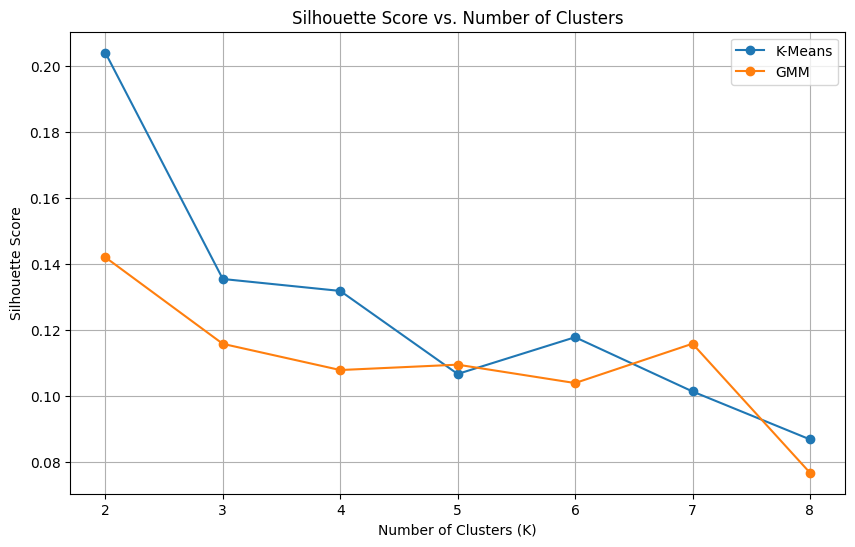

In [10]:
# ---------------------------
# 8. Silhouette Score vs. K Plot for K-Means and GMM
# ---------------------------
silhouette_scores_kmeans = []
silhouette_scores_gmm = []
k_values = range(2, 9)

for k in k_values:
    # K-Means Silhouette Score
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans_labels = kmeans.fit_predict(cluster_train[num_cols_cluster])
    silhouette_scores_kmeans.append(silhouette_score(cluster_train[num_cols_cluster], kmeans_labels))
    
    # GMM Silhouette Score
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels = gmm.fit_predict(cluster_train[num_cols_cluster])
    silhouette_scores_gmm.append(silhouette_score(cluster_train[num_cols_cluster], gmm_labels))

plt.figure(figsize=(10, 6))
plt.plot(list(k_values), silhouette_scores_kmeans, marker='o', label="K-Means")
plt.plot(list(k_values), silhouette_scores_gmm, marker='o', label="GMM")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters")
plt.legend()
plt.grid(True)
plt.show()

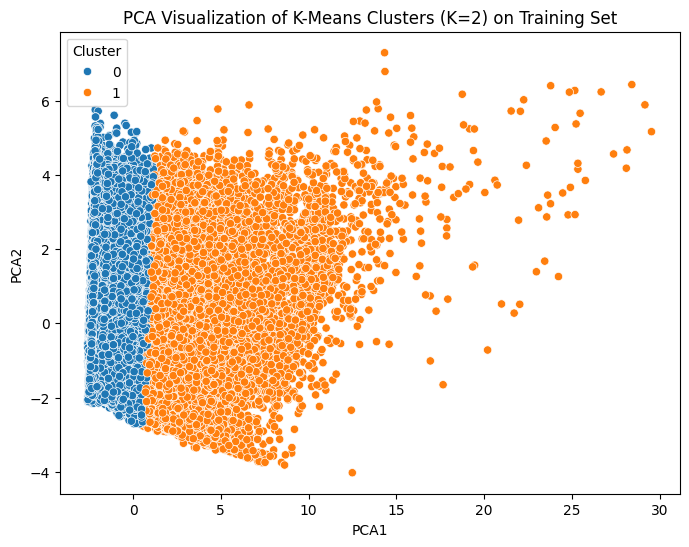

In [11]:
# ---------------------------
# 9. Clustering: Fit on Train & Transform Test (Using K-Means with K=2)
# ---------------------------
best_k = 2
kmeans_best = KMeans(n_clusters=best_k, n_init=10, random_state=42)
train_cluster_labels = kmeans_best.fit_predict(cluster_train[num_cols_cluster])
test_cluster_labels = kmeans_best.predict(cluster_test[num_cols_cluster])

# Add the clustering feature to the original train and test sets
train["Cluster_KMeans_2"] = train_cluster_labels
test["Cluster_KMeans_2"] = test_cluster_labels

# Visualize clustering on train using PCA
pca = PCA(n_components=2)
pca_train = pca.fit_transform(cluster_train[num_cols_cluster])
df_pca_train = pd.DataFrame(pca_train, columns=["PCA1", "PCA2"], index=train.index)
df_pca_train["Cluster_KMeans_2"] = train_cluster_labels

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca_train, x="PCA1", y="PCA2", hue="Cluster_KMeans_2", palette="tab10")
plt.title("PCA Visualization of K-Means Clusters (K=2) on Training Set")
plt.legend(title="Cluster")
plt.show()

In [12]:
corr_matrix = train.corr(numeric_only=True)
corr_matrix["No-show"].sort_values(ascending = False)

No-show                           1.000000
WaitTime_MinMax                   0.264772
WaitTime_Log                      0.264772
WaitTime_Std                      0.264772
Cluster_KMeans_2                  0.191561
poly_2                            0.180964
WaitTime                          0.180964
SMS_received                      0.127649
WaitTime_RollingMean_3            0.126000
WaitTime_Age_Interaction          0.096080
poly_3                            0.096080
WaitTime_Lag_1                    0.056083
Scholarship                       0.032187
NB_ITARARÉ                        0.027286
NB_SANTOS DUMONT                  0.023319
NB_JESUS DE NAZARETH              0.017599
NB_ILHA DO PRÍNCIPE               0.014085
NB_SANTA CECÍLIA                  0.011910
NB_SANTA CLARA                    0.011646
NB_ANDORINHAS                     0.010530
NB_CARATOÍRA                      0.010297
NB_ILHAS OCEÂNICAS DE TRINDADE    0.009451
hashed_0                          0.007964
NB_SÃO JOSÉ

In [13]:
# ---------------------------
# 10. Handling Imbalanced Data (SMOTE) on Training Set
# ---------------------------
# Select a subset of features for modeling (example: Age, WaitTime_Std, and one-hot NB_ features)
model_features = ['WaitTime_Std', 'Cluster_KMeans_2']
nb_features = [col for col in train.columns if col.startswith("NB_")]
if 'ChronicCount' in train.columns:
    model_features.append('ChronicCount')
model_features.extend(nb_features)

# Ensure the target column is 'No-show'
X_train = train[model_features]
y_train = train['No-show']
print("Before SMOTE, target distribution:\n", y_train.value_counts())

if len(y_train.unique()) > 1:
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    print("After SMOTE, target distribution:\n", pd.Series(y_train_res).value_counts())
    # (Optionally, you could update train with the resampled data for modeling)
else:
    print("⚠️ SMOTE skipped: Only one class present in y.")

Before SMOTE, target distribution:
 No-show
0    70553
1    17868
Name: count, dtype: int64


/Users/nandinisankarabukta/nandinisankarabukta-git/Medical_Appointment_NoShow/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


After SMOTE, target distribution:
 No-show
0    70553
1    70553
Name: count, dtype: int64


In [15]:
# ---------------------------
# 12. Save Final Processed Datasets
# ---------------------------

# Save processed train and test datasets (with clustering feature added)
train.to_csv("/Users/nandinisankarabukta/nandinisankarabukta-git/Medical_Appointment_NoShow/data/processed_train_data.csv", index=False)
test.to_csv("/Users/nandinisankarabukta/nandinisankarabukta-git/Medical_Appointment_NoShow/data/processed_test_data.csv", index=False)

print("Feature engineering and clustering completed successfully!")

Feature engineering and clustering completed successfully!
